### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Imports</p>


In [1]:
import umap

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
from collections import Counter
from scipy.stats import chi2
# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from catboost.utils import get_roc_curve

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
original_df = pd.read_csv('./cubic_zirconia.csv', index_col=[0])
original_dict = pd.read_excel('./Data Dictionary.xlsx')

train_df = pd.read_csv('./train.csv', index_col=[0])
test_df = pd.read_csv('./test.csv', index_col=[0])
sample_sub = pd.read_csv('./sample_submission.csv', index_col=[0])

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">EDA and data clean</p>


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 193573 entries, 0 to 193572

Data columns (total 10 columns):

 #   Column   Non-Null Count   Dtype  

---  ------   --------------   -----  

 0   carat    193573 non-null  float64

 1   cut      193573 non-null  object 

 2   color    193573 non-null  object 

 3   clarity  193573 non-null  object 

 4   depth    193573 non-null  float64

 5   table    193573 non-null  float64

 6   x        193573 non-null  float64

 7   y        193573 non-null  float64

 8   z        193573 non-null  float64

 9   price    193573 non-null  int64  

dtypes: float64(6), int64(1), object(3)

memory usage: 16.2+ MB


In [4]:
original_df=original_df.dropna()

In [5]:
(original_df.describe() - train_df.describe())

,carat,depth,table,x,y,z,price
count,-167303.000000,-167303.000000,-167303.000000,-167303.000000,-167303.000000,-167303.000000,-167303.000000
mean,0.007307,-0.075428,0.228336,0.013855,0.012873,0.002390,-31.181680
std,0.014527,0.331156,0.311932,0.018093,0.063997,0.010413,-12.184797
min,0.000000,-1.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.300000,0.000000,0.010000,0.010000,0.000000,-6.000000
50%,0.000000,-0.100000,0.000000,-0.010000,-0.020000,-0.010000,-26.000000
75%,0.020000,0.100000,1.000000,0.040000,0.030000,0.010000,-47.000000
max,1.000000,2.000000,0.000000,0.580000,48.890000,-23.240000,0.000000


In [6]:
# Dimensions must be positive
original_df=original_df[(original_df['x']>0.000) & (original_df['y']>0.000) & (original_df['z']>0.000)]
train_df=train_df[(train_df['x']>0.000) & (train_df['y']>0.000) & (train_df['z']>0.000)]


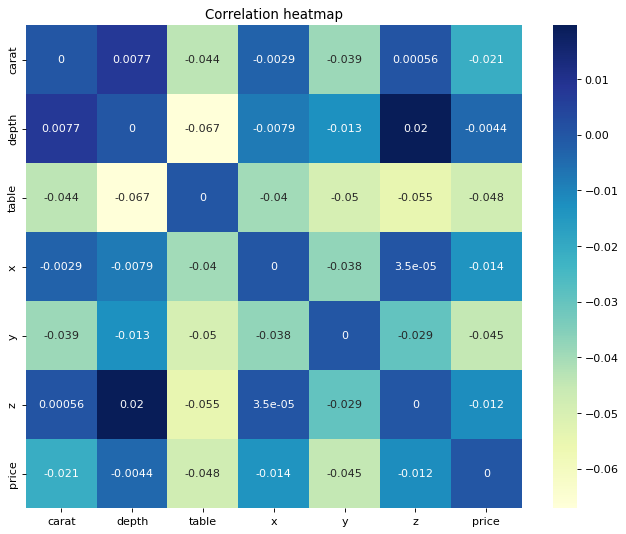

In [7]:
plt.figure(figsize=(10, 8), dpi=80)
sns.heatmap(original_df.corr() - train_df.corr(), cmap="YlGnBu", annot=True)
plt.title('Correlation heatmap')
plt.show()

In [45]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
cat_cols= ['cut', 'color', 'clarity']
num_cols= ['carat', 'depth', 'table', 'x', 'y', 'z', 'price']
target='price'

### Outiers detection using Malahanobis distance

In [9]:
def MahalanobisDist(data):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [10]:
original_df['Mahalanobis_dist'] = MahalanobisDist(data=original_df[num_cols].values)

orig_cutoff=chi2.ppf(0.95, original_df.shape[1])

In [10]:
original_df[original_df['Mahalanobis_dist'] >=orig_cutoff ].describe()

(original_df[original_df['Mahalanobis_dist']<=orig_cutoff].describe() - 
 original_df[original_df['Mahalanobis_dist'] >=orig_cutoff ].describe()).T.style.background_gradient(subset=['std'], cmap='Greens').background_gradient(subset=['mean'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
carat,26245.000000,-0.694907,-0.882456,-0.180000,-0.072500,-0.600000,-0.627500,-0.490000
depth,26245.000000,-0.792397,-1.430220,-8.100000,0.175000,0.250000,-1.725000,6.300000
table,26245.000000,-0.544913,-1.275601,-5.000000,-0.750000,-0.500000,1.000000,13.000000
x,26245.000000,-1.077153,-0.866805,-0.780000,-0.225000,-1.335000,-1.370000,-0.090000
y,26245.000000,-7.359005,-17.472403,-0.970000,-0.852500,-0.645000,-1.625000,-48.800000
z,26245.000000,-0.563574,-1.800012,1.170000,0.972500,-0.635000,-1.435000,-1.750000
price,26245.000000,-3248.005133,-2159.694754,-142.000000,-957.000000,-4646.000000,-4424.750000,287.000000
Mahalanobis_dist,26245.000000,-58.460479,-44.983563,-20.451732,-27.866184,-43.405354,-76.123547,-140.229817


In [11]:
train_df['Mahalanobis_dist'] = MahalanobisDist(data=train_df[num_cols].values)

train_cutoff=chi2.ppf(0.95, train_df.shape[1])
train_df[train_df['Mahalanobis_dist'] >=train_cutoff ].describe()

(train_df[train_df['Mahalanobis_dist']<=train_cutoff].describe() - 
 train_df[train_df['Mahalanobis_dist'] >=train_cutoff ].describe()).T.style.background_gradient(subset=['std'], cmap='Greens').background_gradient(subset=['mean'], cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
carat,193537.000000,-0.985575,-0.517532,-0.300000,-0.670000,-1.310000,-1.190000,0.100000
depth,193537.000000,0.174466,-1.413352,-3.200000,0.100000,0.100000,-0.400000,5.700000
table,193537.000000,-1.157146,-0.549011,-6.000000,-1.000000,-1.000000,-2.000000,15.000000
x,193537.000000,-1.859429,-0.282483,-1.300000,-1.910000,-2.380000,-1.910000,0.230000
y,193537.000000,-1.734671,-0.408377,-1.380000,-1.910000,-2.290000,-1.810000,-0.420000
z,193537.000000,-3.746592,-6.855301,1.190000,-1.420000,-2.060000,-4.150000,-25.270000
price,193537.000000,-6140.707579,-2556.883765,-1042.000000,-4175.000000,-8969.000000,-9901.000000,82.000000
Mahalanobis_dist,193537.000000,-58.771919,-106.142343,-19.926656,-20.932815,-25.907222,-45.441439,-398.239660


In [12]:
train_df = train_df[train_df['Mahalanobis_dist'] <=train_cutoff ]

original_df = original_df[original_df['Mahalanobis_dist'] <=orig_cutoff ]

### Adversarial validation original/train df


I'm gonna train a catboost classifier to understand how and if the orginal and the train dfs are distinguishable

In [27]:
original_df['dataset_label'] = 'original'
train_df['dataset_label'] = 'train'
aux_target = 'dataset_label'

In [ ]:
# One-hot encoding cat features
full_df = pd.concat([original_df, train_df])
full_dummies_df = pd.get_dummies(full_df, columns=cat_cols)
original_dummies_df = pd.get_dummies(original_df, columns=cat_cols)
train_dummies_df = pd.get_dummies(train_df, columns=cat_cols)
test_df = pd.get_dummies(test_df, columns=cat_cols)

In [47]:

aux_cols = ['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'dataset_label']

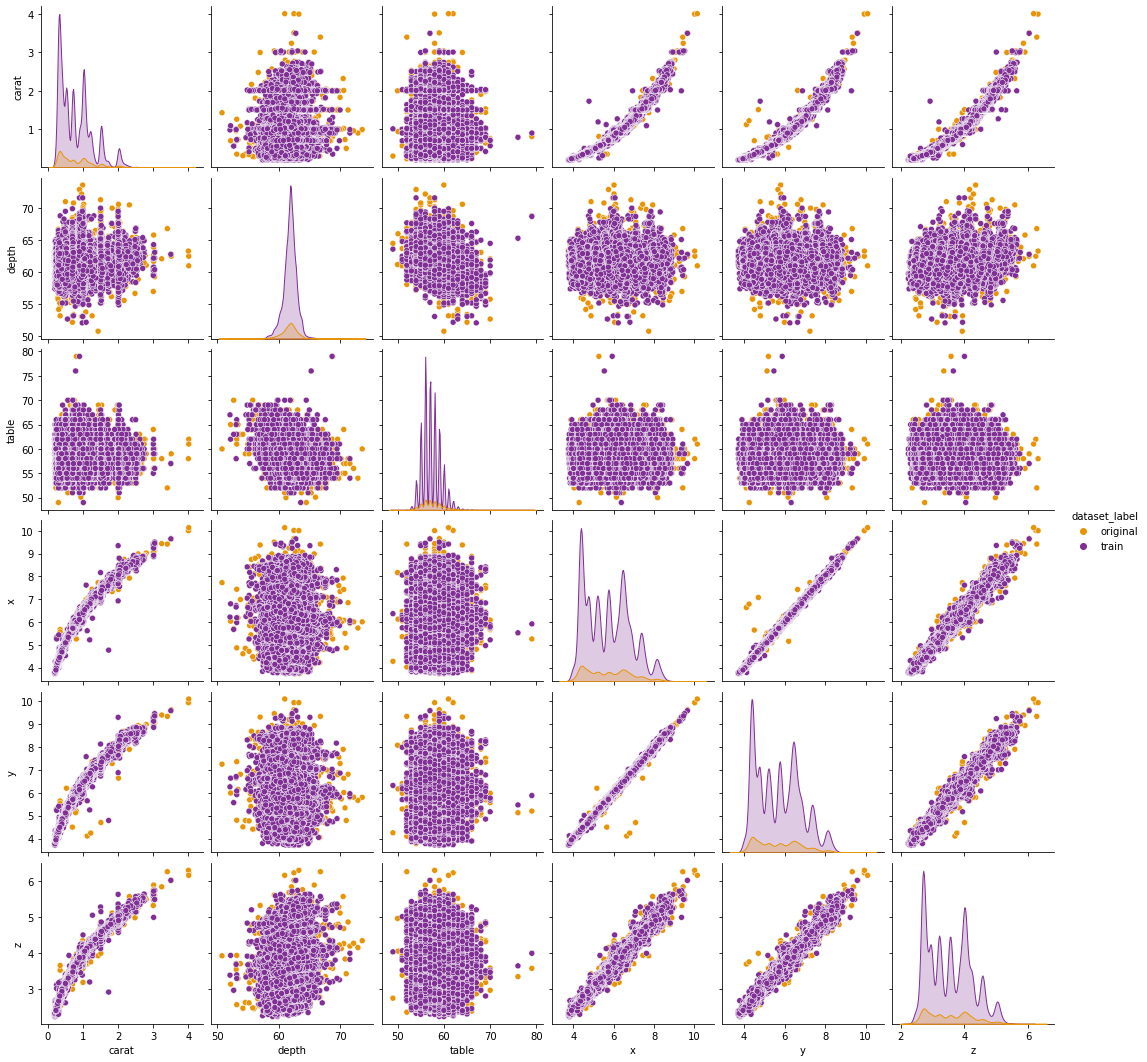

In [61]:
sns.pairplot(full_dummies_df[aux_cols].drop("price", axis=1).reset_index(drop=True), hue='dataset_label', palette='CMRmap_r')

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Adversarial validation</p>

In [82]:
def create_adversarial_data(df_1, df_2, cols, N_val=50000):
    df_master = pd.concat([df_1[cols], df_2[cols]], axis=0)
    adversarial_val = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_val.index)]
    return adversarial_train, adversarial_val

features = list(original_dummies_df.drop(['dataset_label', 'Mahalanobis_dist'], axis=1).columns)
all_cols = features + [aux_target]
adversarial_train, adversarial_test = create_adversarial_data(original_dummies_df, train_dummies_df, all_cols)

In [83]:
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[aux_target]
)

holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[aux_target]    
)

In [84]:
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
}

model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data, verbose=0)

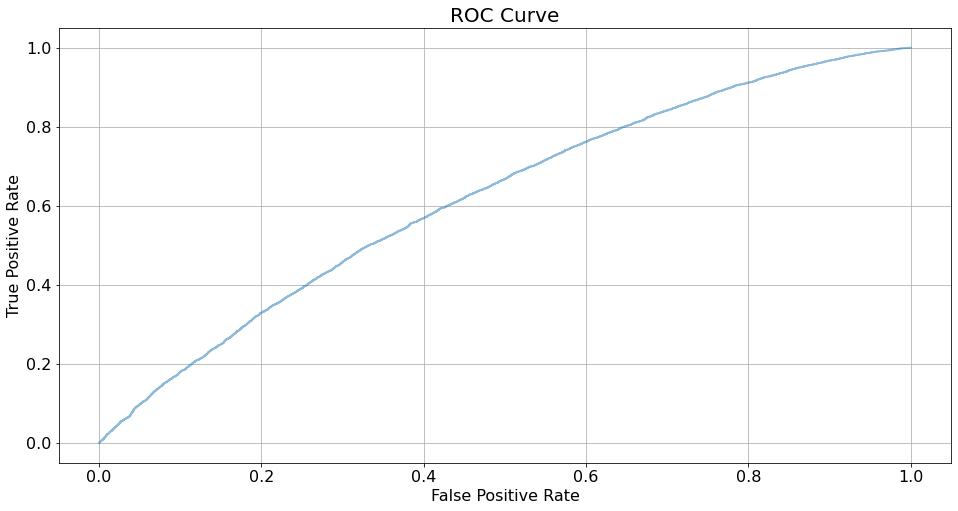

In [85]:
# Receiver Operator Characteristic Curve
_ = get_roc_curve(model, 
                  holdout_data,
                  thread_count=-1,
                  plot=True)

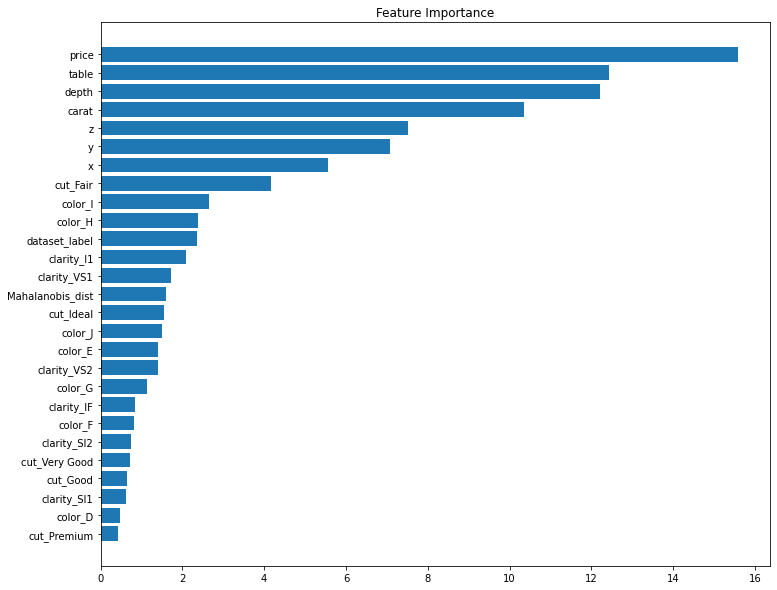

In [87]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(original_dummies_df.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

### Manifold representation

#### Legend: -1 correspond to train dataset, 1 to original

In [101]:
import umap.umap_ as umap
import umap.plot

In [110]:
aux_df=full_dummies_df[aux_cols].iloc[::10, :]

In [111]:
mapper = _umap.UMAP(n_neighbors=5, min_dist=0.3).fit(aux_df.drop('dataset_label', axis=1).values)

In [125]:
codes = {'original':1, 'train':-1}

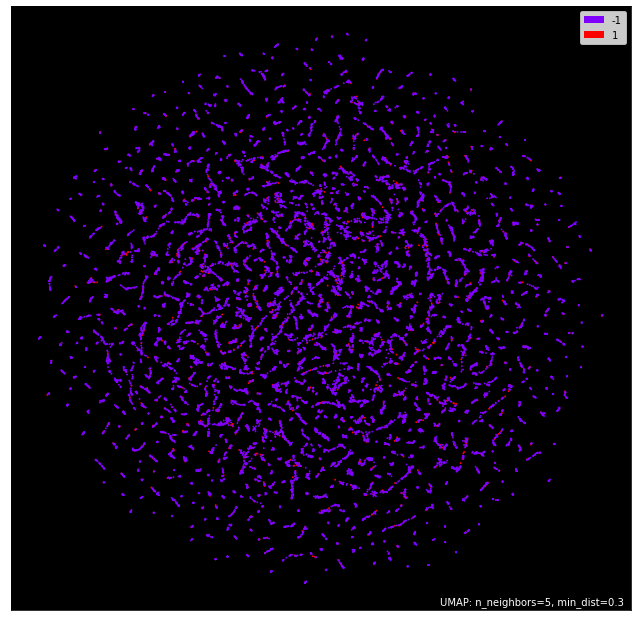

In [124]:
umap.plot.points(mapper, aux_df['dataset_label'].map(codes), background='black', theme='fire')
plt.show()

<div class='alert alert-block alert-success'><b>Insights:</b>
Safe to say that data from original and train dataset are equally distributed

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Features eng</p>

### Density 
Typical cubic zirconia=5.6-6.0 g/cm3

In [126]:
full_dummies_df['weight_g']=np.round(full_dummies_df['carat']/5, 4)
full_dummies_df['V_cm3']=np.round((full_dummies_df['x']*full_dummies_df['y']*full_dummies_df['z']/1000), 4)
full_dummies_df['rho_g_cm3']=np.round(full_dummies_df['carat']/full_dummies_df['V_cm3'], 2)

In [127]:
test_df['weight_g']=np.round(test_df['carat']/5, 4)
test_df['V_cm3']=np.round((test_df['x']*test_df['y']*test_df['z']/1000), 4)
test_df['rho_g_cm3']=np.round(test_df['carat']/test_df['V_cm3'], 2)

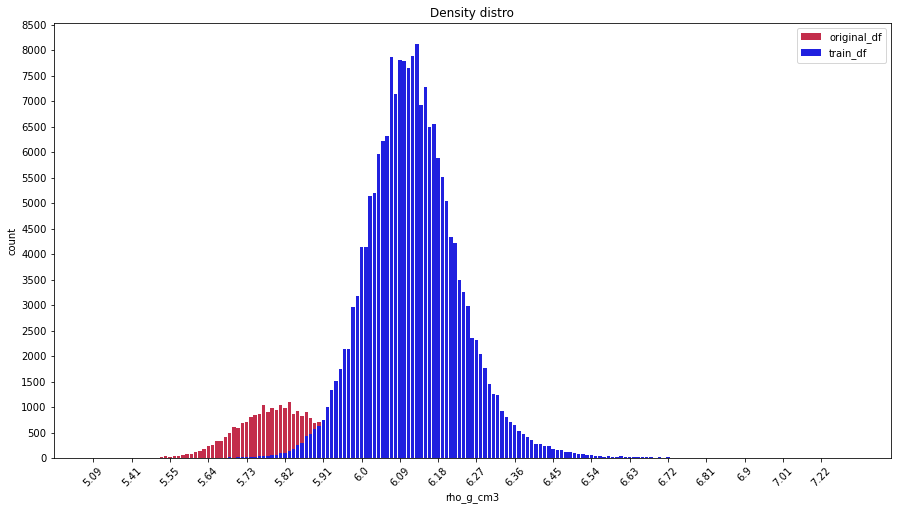

In [132]:
plt.figure(figsize=(15, 8))
sns.countplot(data=full_dummies_df[full_dummies_df['dataset_label']=='original'], 
              x='rho_g_cm3', 
              color='crimson',
              label="original_df")
sns.countplot(data=full_dummies_df[full_dummies_df['dataset_label']=='train'], 
              x='rho_g_cm3', 
              color='blue',
              label="train_df")

plt.xticks(rotation=45)
plt.locator_params(nbins=20)
plt.title('Density distro')
plt.legend()
plt.show()

In [182]:
# Cleaning for unlikely density values
full_dummies_df = full_dummies_df[full_dummies_df['rho_g_cm3']<=6.9]
full_dummies_df = full_dummies_df[full_dummies_df['rho_g_cm3']>=5.1]

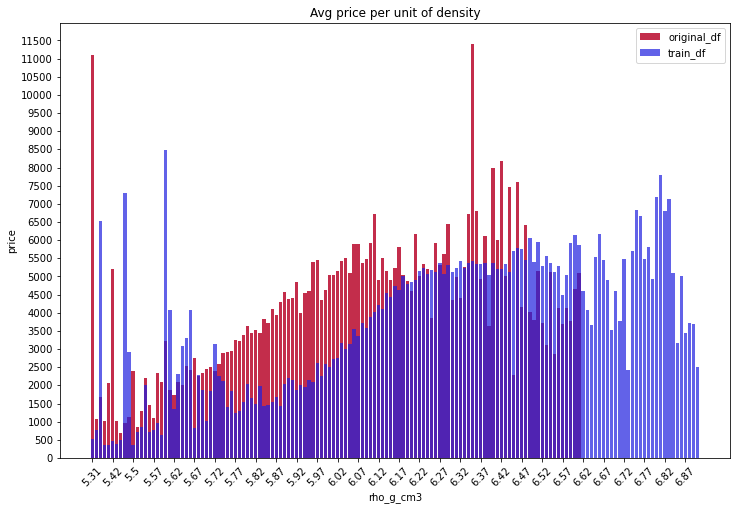

In [183]:
plt.figure(figsize=(12, 8))
sns.barplot(x=full_dummies_df[full_dummies_df['dataset_label']=='original'].groupby('rho_g_cm3')['price'].mean().index, 
            y=full_dummies_df[full_dummies_df['dataset_label']=='original'].groupby('rho_g_cm3')['price'].mean(), 
            color='crimson',
            label="original_df")
          

sns.barplot(x=full_dummies_df[full_dummies_df['dataset_label']=='train'].groupby('rho_g_cm3')['price'].mean().index, 
            y=full_dummies_df[full_dummies_df['dataset_label']=='train'].groupby('rho_g_cm3')['price'].mean(),
            color='blue', alpha=.7,
            label="train_df")
plt.xticks(rotation=45)
plt.legend()
plt.locator_params(nbins=30)
plt.title('Avg price per unit of density')
plt.show()

In [184]:
full_dummies_df['price_per_umass'] = (full_dummies_df['price'] / full_dummies_df['carat']).astype(int)

In [198]:
full_dummies_df['price_per_umass'].describe()['mean'] + 4*full_dummies_df['price_per_umass'].describe()['std'] 

11955.021522716928

In [200]:
full_dummies_df[full_dummies_df['price_per_umass']>=10000]

,carat,depth,table,x,y,z,price,Mahalanobis_dist,dataset_label,cut_Fair,...,V_cm3,rho_g_cm3,price_per_umass,y_carat,x_carat,area,area_carat,depth_per_volume,depth_per_density,depth_per_table
21,1.04,61.1,60.0,6.54,6.51,3.99,10984,4.047767,original,0,...,0.1699,6.12,10561,6.7704,6.8016,42.5754,0.024427,359.621191,9.983658,1.018333
216,1.50,60.5,55.0,7.39,7.48,4.50,15585,4.521996,original,0,...,0.2487,6.03,10390,11.2200,11.0850,55.2772,0.027136,243.264000,10.033166,1.100000
317,1.04,61.8,57.0,6.49,6.52,4.02,14494,6.036539,original,0,...,0.1701,6.11,13936,6.7808,6.7496,42.3148,0.024578,363.313561,10.114565,1.084211
382,1.22,61.2,57.0,6.88,6.92,4.22,13029,4.115591,original,0,...,0.2009,6.07,10679,8.4424,8.3936,47.6096,0.025625,304.627652,10.082371,1.073684
397,1.20,61.1,55.0,6.86,6.89,4.20,13088,4.379893,original,0,...,0.1985,6.05,10906,8.2680,8.2320,47.2654,0.025389,307.807014,10.099172,1.110909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192569,1.01,61.3,54.0,6.49,6.47,3.97,10308,4.645017,train,0,...,0.1667,6.06,10205,6.5347,6.5549,41.9903,0.024053,367.724249,10.115510,1.135185
192752,1.00,62.3,60.0,6.36,6.32,3.95,10800,5.170614,train,0,...,0.1588,6.30,10800,6.3200,6.3600,40.1952,0.024879,392.314910,9.888887,1.038333
192797,1.50,61.9,60.0,7.30,7.34,4.53,15529,5.247386,train,0,...,0.2427,6.18,10352,11.0100,10.9500,53.5820,0.027994,255.046333,10.016180,1.031667
193389,1.50,60.9,60.0,7.30,7.32,4.46,15308,4.871130,train,0,...,0.2383,6.29,10205,10.9800,10.9500,53.4360,0.028071,255.559146,9.682033,1.015000


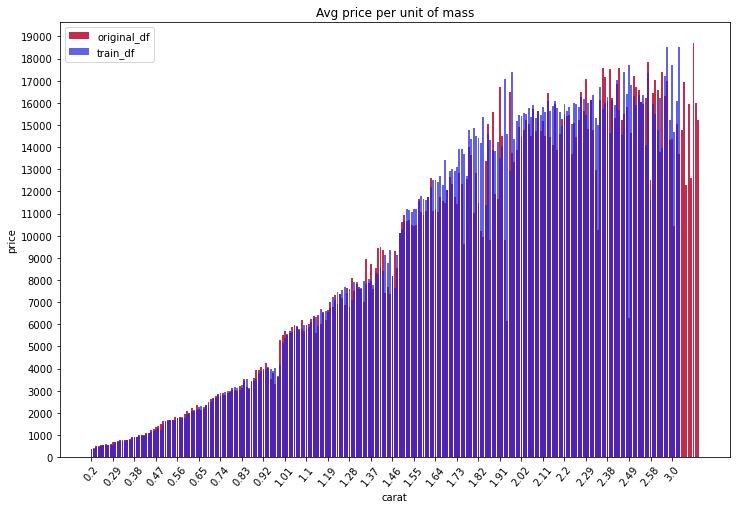

In [186]:
plt.figure(figsize=(12, 8))
sns.barplot(x=full_dummies_df[full_dummies_df['dataset_label']=='original'].groupby('carat')['price'].mean().index, 
            y=full_dummies_df[full_dummies_df['dataset_label']=='original'].groupby('carat')['price'].mean(), 
            color='crimson',
            label="original_df")
          

sns.barplot(x=full_dummies_df[full_dummies_df['dataset_label']=='train'].groupby('carat')['price'].mean().index, 
            y=full_dummies_df[full_dummies_df['dataset_label']=='train'].groupby('carat')['price'].mean(),
            color='blue', alpha=.7,
            label="train_df")
plt.xticks(rotation=50)
plt.legend()
plt.locator_params(nbins=30)
plt.title('Avg price per unit of mass')
plt.show()

<div class='alert alert-block alert-success'><b>Insights:</b>
Price per does not go linearly with mass!

### Other features

In [187]:
test_df['y_carat'] = test_df['y'] * test_df['carat']
test_df['x_carat'] = test_df['x'] * test_df['carat']
test_df['area'] = test_df['y'] * test_df['x']
test_df['area_carat'] = test_df['carat'] / (test_df['area'] + 1e-6)

test_df['depth_per_volume'] = test_df['depth'] / (test_df['V_cm3'] + 1e-6)
test_df['depth_per_density'] = test_df['depth'] / (test_df['rho_g_cm3'] + 1e-6)
test_df['depth_per_table'] = test_df['depth'] / (test_df['table'] + 1e-6)

In [188]:
full_dummies_df['y_carat'] = full_dummies_df['y'] * full_dummies_df['carat']
full_dummies_df['x_carat'] = full_dummies_df['x'] * full_dummies_df['carat']
full_dummies_df['area'] = full_dummies_df['y'] * full_dummies_df['x']
full_dummies_df['area_carat'] = full_dummies_df['carat'] / (full_dummies_df['area'] + 1e-6)

full_dummies_df['depth_per_volume'] = full_dummies_df['depth'] / (full_dummies_df['V_cm3'] + 1e-6)
full_dummies_df['depth_per_density'] = full_dummies_df['depth'] / (full_dummies_df['rho_g_cm3'] + 1e-6)
full_dummies_df['depth_per_table'] = full_dummies_df['depth'] / (full_dummies_df['table'] + 1e-6)

In [191]:
features_full=['carat', 'depth', 'table', 'x', 'y', 'z',
       'cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
       'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2',
       'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2',
       'weight_g', 'V_cm3', 'rho_g_cm3', 
       'y_carat', 'x_carat', 'area', 'area_carat', 'depth_per_volume',
       'depth_per_density', 'depth_per_table']

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Modeling [To be enhanced]</p>


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [87]:
X_train, X_val, y_train, y_val = train_test_split(full_dummies_df.drop(['price', 'dataset_label'], axis=1), 
                                                    full_dummies_df['price'],test_size=.2,random_state =123)

In [93]:
from catboost import CatBoostRegressor
import numpy as np

model = CatBoostRegressor(logging_level='Silent')

grid = {
        'iterations': [500, 700, 1000],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'depth': [8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5, 7, 9],

           }

grid_search_result = model.grid_search(grid, 
                                       X=full_dummies_df[features_dummies], 
                                       y=full_dummies_df['price'], 
                                       plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Text(0.5, 1.0, 'Feature Importance')

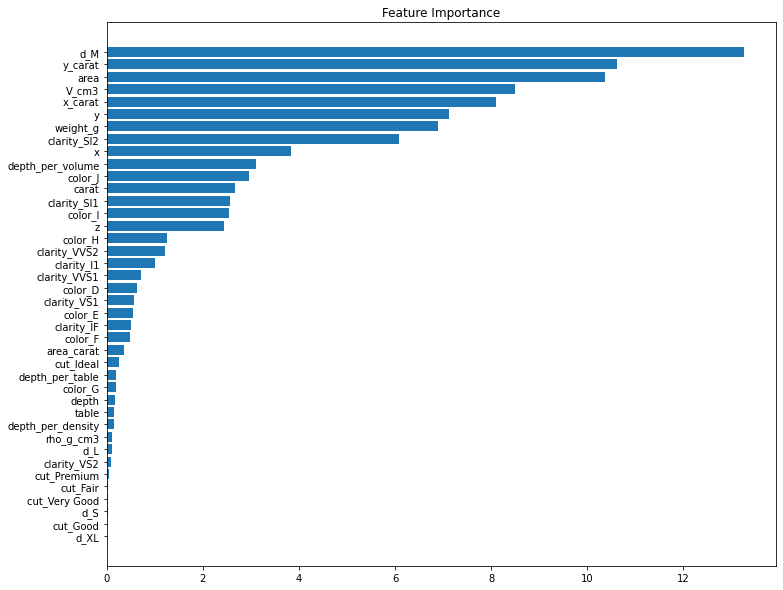

In [96]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'SHAP Importance')

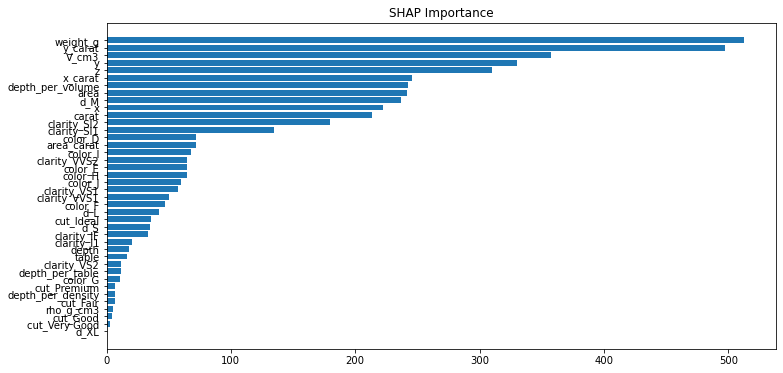

In [98]:
explainer = shap.Explainer(model)
shap_values = explainer(X_val)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('SHAP Importance')


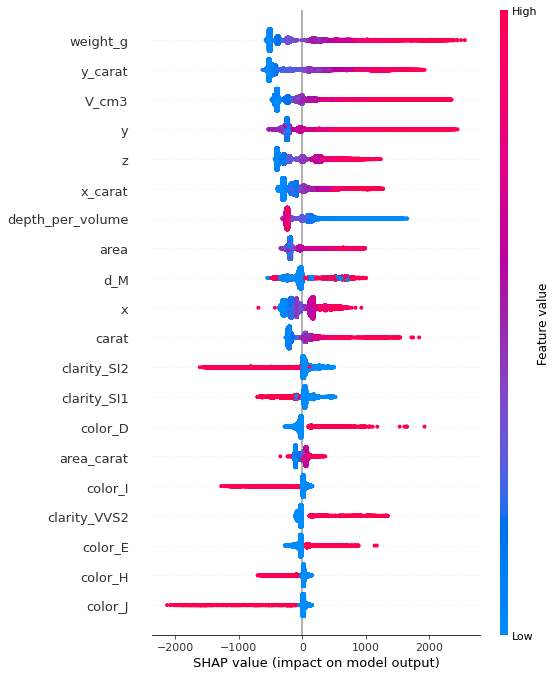

In [100]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, feature_names = features_dummies)

In [115]:
best_params={'n_estimators': 9999,
             'depth': 8,
             'l2_leaf_reg': 5,
             'learning_rate': 0.05 ,
              'loss_function': 'RMSE',
            'logging_level':'Silent'}

model = CatBoostRegressor(**best_params)

In [116]:
cat_features_index = np.where(X_train.dtypes != float)[0]
train_pool = Pool(X_train, y_train, cat_features=cat_features_index)


model.fit(train_pool, eval_set=(X_val,y_val))

In [112]:
y_pred = model.predict(test_df)

In [114]:
sample_sub['price']=y_pred
sample_sub.to_csv('submission.csv')